## Research Question 
people think that SPEED is good indicator on which tier a pokemon will fall into but in reality X is better indicator

- Can we predict what kind of pokemon will be good later? 
- Why: because I (Brennan Chan) compete in competitive singles pokemon I was curious which is a better indicatior on tiering BST or Speed 

In [107]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import requests

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# K means 
from sklearn.cluster import KMeans

In [56]:
# just testing pokemon api 
def get_pokemon(gen_name):
    check = f"https://smogonapi.herokuapp.com/GetPokemonByGen/{gen_name}/"
    
    response = requests.get(check)
        
        # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        matches = response.json()
        return matches
    else:
        print("Error:", response.status_code)
        return None

In [57]:
# list of Good abilities there should be more 
GoodAbil = ['Poison Heal', 'Technician', 'Unaware', 'Static', 'Regenerator',
            'Magic Guard', 'Libero', 'Good as Gold', 'Contrary', 'Protean', 
            'Multiscale', 'Speed Boost', 'Huge Power', 'Wonder Guard']

In [58]:
sv_pokemon = get_pokemon("sv")

print(type(sv_pokemon))

sv_pokemon_df = pd.json_normalize(sv_pokemon)

print(sv_pokemon_df)

<class 'list'>
                    name   hp  atk  def  spa  spd  spe  weight  height  \
0              Stratagem   90   60   65  120   70  130    45.0     0.9   
1              Arghonaut  105  110   95   70  100   75   151.0     1.7   
2               Kitsunoh   80  103   85   55   80  110    51.0     1.1   
3                Cyclohm  108   60  118  112   70   80    59.0     1.6   
4              Colossoil  133  122   72   71   72   95   683.6     2.6   
...                  ...  ...  ...  ...  ...  ...  ...     ...     ...   
1350  Meloetta-Pirouette  100  128   90   77   77  128     6.5     0.6   
1351       Inteleon-Gmax   70   85   65  125   65  120     0.0    40.0   
1352       Kyogre-Primal  100  150   90  180  160   90   430.0     9.8   
1353   Cramorant-Gulping   70   85   55   85   95   85    18.0     0.8   
1354       Appletun-Gmax  110   85   80  100   80   30     0.0    24.0   

                   types                       abilities         formats  \
0                 [R

In [59]:
for cols in sv_pokemon_df.columns:
    print(cols)

name
hp
atk
def
spa
spd
spe
weight
height
types
abilities
formats
isNonstandard
oob.dex_number
oob.evos
oob.alts
oob.genfamily
oob


In [62]:
# filter out non standard 
def filter_lists(lst):
    return 'Standard' in lst

# filter out little cup 
def contains_lc(arr):
    return 'LC' in arr

In [64]:
# Apply the function to filter out rows
filtered_df = sv_pokemon_df[sv_pokemon_df['isNonstandard'].apply(filter_lists)]
filtered_df = filtered_df[~filtered_df['formats'].apply(contains_lc)]

print(filtered_df)

                    name   hp  atk  def  spa  spd  spe  weight  height  \
40             Gholdengo   87   60   95  133   91   84    30.0     1.2   
41              Wo-Chien   85   85  100   95  135   70    74.2     1.5   
42             Chien-Pao   80  120   80   90   65  135   152.2     1.9   
43               Ting-Lu  155  110  125   55   80   45   699.7     2.7   
44                Chi-Yu   55   80   80  135  120  100     4.9     0.4   
...                  ...  ...  ...  ...  ...  ...  ...     ...     ...   
1289       Minior-Meteor   60   60  100   60  100   60    40.0     0.3   
1290   Ogerpon-Teal-Tera   80  120   84   60   96  110    39.8     1.2   
1301        Palafin-Hero  100  160   97  106   87  100    97.4     1.8   
1350  Meloetta-Pirouette  100  128   90   77   77  128     6.5     0.6   
1353   Cramorant-Gulping   70   85   55   85   95   85    18.0     0.8   

                   types               abilities formats isNonstandard  \
40        [Steel, Ghost]          [Go

In [65]:
# tier ranking 
unique_values = filtered_df['isNonstandard'].explode().unique()
unique_values

# formats  
unique_values = filtered_df['formats'].explode().unique()
unique_values

array(['OU', 'PU', 'Uber', 'ZU', 'RU', 'UU', 'NU', 'UUBL', 'NFE', 'NUBL',
       'ZUBL', 'RUBL', 'PUBL', 'AG'], dtype=object)

In [98]:
def Tier_Define(df):
    # the lower the value the better the tier with anything less than 1 being banned
    mapping = {'OU': 1, 'PU': 5, 'Uber': 0, 'ZU': 6, 'RU': 3, 'UU': 2, 'NU': 4,
                'UUBL': 1.5, 'NFE': 7, 'NUBL': 3.5, 'ZUBL': 5.5, 'RUBL': 2.5, 'PUBL': 4.5, 'AG': -1}
    
    # Function to handle lists in the 'formats' column
    def map_format(x):
        if isinstance(x, list):
            if x:
                return mapping.get(x[0])  # Map the first element of the list
            else:
                return None
        else:
            return mapping.get(x)
    
    # Apply the mapping function to the 'formats' column
    df['mapped_tiers'] = df['formats'].apply(map_format)
    
    return df

def Sort_Mons_names(df):
    sorted_df = df.sort_values(by='name')
    return sorted_df

def get_bst(df):
    ans = df
    columns_to_sum = ['hp', 'atk', 'def', 'spa', 'spd', 'spe']
    ans['bst'] = df[columns_to_sum].sum(axis=1)
    # ans['bst'] = df[['hp', 'atk', 'def', 'spa', 'spd', 'spe']].sum(axis=1)
    
    return ans

In [99]:
defined_df = Tier_Define(filtered_df)
# For debugging 
# print(defined_df.head())

sort_name_df = Sort_Mons_names(defined_df)
# For debugging 
# print(sort_name_df.head())

bst_df = get_bst(sort_name_df)
# For debugging 
print(bst_df.head())


           name   hp  atk  def  spa  spd  spe  weight  height  \
512   Abomasnow   90   92   75   92   85   60   135.5     2.2   
184       Aipom   55   70   55   40   55   85    11.5     0.8   
1080   Alcremie   65   60   75  110  121   64     0.5     0.3   
702   Alomomola  165   75   80   40   45   65    31.6     1.2   
365     Altaria   75   70   90   70  105   80    20.6     1.1   

                 types                         abilities formats  \
512       [Grass, Ice]        [Snow Warning, Soundproof]    [ZU]   
184           [Normal]    [Run Away, Pickup, Skill Link]   [NFE]   
1080           [Fairy]          [Sweet Veil, Aroma Veil]    [PU]   
702            [Water]  [Healer, Hydration, Regenerator]    [OU]   
365   [Dragon, Flying]        [Natural Cure, Cloud Nine]    [PU]   

     isNonstandard  oob.dex_number   oob.evos          oob.alts  \
512       Standard           460.0         []  [Abomasnow-Mega]   
184       Standard           190.0  [Ambipom]                []   

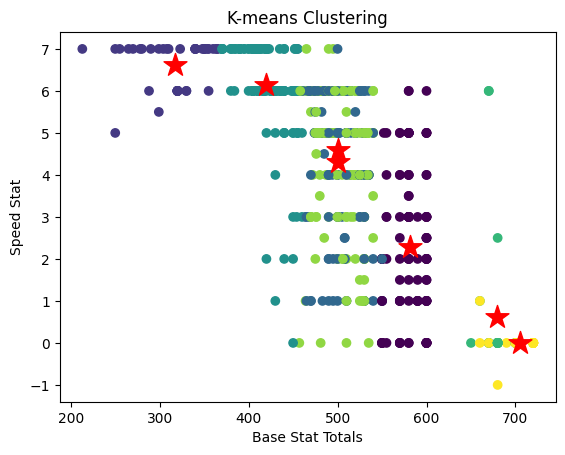

In [103]:
selected_features = ['bst', 'mapped_tiers', 'spe']

X = bst_df[selected_features]

# Perform K-means clustering
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_


plt.scatter(bst_df['bst'], bst_df['mapped_tiers'], c=cluster_labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], marker='*', c='red', s=300)  # Plot cluster centers
plt.xlabel('Base Stat Totals')
plt.ylabel('Speed Stat')
plt.title('K-means Clustering')
plt.show()

# Analysis 
There seems to be pretty clusters with speed and bst, they even look like they are separated into their own tiers which is good for our analysis. 

IndexError: index 1 is out of bounds for axis 1 with size 1

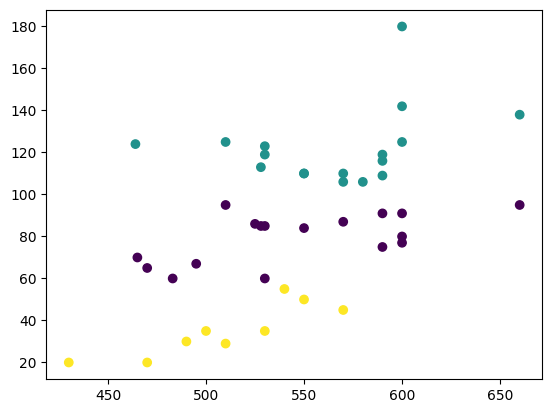

In [105]:
# Filter only tier one Pokémon
tier_one_df = bst_df[bst_df['mapped_tiers'] == 1]

# Select speed attribute for clustering
X = tier_one_df[['spe']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_

# Visualize the clustering results
plt.scatter(tier_one_df['bst'], tier_one_df['spe'], c=cluster_labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], marker='*', c='red', s=300)  # Plot cluster centers
plt.xlabel('Base Stat Totals')
plt.ylabel('Speed Stat')
plt.title('K-means Clustering for Tier One Pokémon')
plt.show()

In [106]:
# Define binary search tree node class
class TreeNode:
    def __init__(self, speed):
        self.speed = speed
        self.left = None
        self.right = None

# Function to insert a node into the binary search tree
def insert(root, speed):
    if root is None:
        return TreeNode(speed)
    if speed < root.speed:
        root.left = insert(root.left, speed)
    else:
        root.right = insert(root.right, speed)
    return root

# Function to construct the binary search tree
def construct_bst(data):
    root = None
    for speed in data:
        root = insert(root, speed)
    return root

# Construct the binary search tree
root = construct_bst(tier_one_df['spe'])

# Function to search for a specific speed in the binary search tree
def search(root, target):
    if root is None or root.speed == target:
        return root
    if target < root.speed:
        return search(root.left, target)
    return search(root.right, target)

# Example: Search for a specific speed in the binary search tree
target_speed = 30
result_node = search(root, target_speed)
if result_node:
    print(f"Tier one Pokémon with speed {target_speed} found!")
else:
    print(f"No tier one Pokémon found with speed {target_speed}.")

Tier one Pokémon with speed 30 found!


In [112]:
# Prepare the data
X_bst = bst_df[['bst']]
X_speed = bst_df[['spe']]
X_both = bst_df[['bst', 'spe']]
y = bst_df['mapped_tiers']

# Split the data into training and testing sets
X_bst_train, X_bst_test, y_train, y_test = train_test_split(X_bst, y, test_size=0.2, random_state=42)
X_speed_train, X_speed_test, _, _ = train_test_split(X_speed, y, test_size=0.2, random_state=42)
X_both_train, X_both_test, _, _ = train_test_split(X_both, y, test_size=0.2, random_state=42)

# Train linear regression models
model_bst = LinearRegression()
model_speed = LinearRegression()
model_both = LinearRegression()

model_bst.fit(X_bst_train, y_train)
model_speed.fit(X_speed_train, y_train)
model_both.fit(X_both_train, y_train)

# Evaluate the models
mse_bst = mean_squared_error(y_test, model_bst.predict(X_bst_test))
mse_speed = mean_squared_error(y_test, model_speed.predict(X_speed_test))
mse_both = mean_squared_error(y_test, model_both.predict(X_both_test))

print("MSE (BST):", mse_bst)
print("MSE (Speed):", mse_speed)
print("MSE (BST and Speed):", mse_both)


MSE (BST): 2.2682954466165772
MSE (Speed): 4.596786208587854
MSE (BST and Speed): 2.2060378713100643


### Analysis Results 
With this analysis it is evident that a model predicting with BST is much more accurate than a model predicting with just speed. 

Accuracy (BST): 0.4496124031007752
Accuracy (Speed): 0.24806201550387597
Accuracy (BST and Speed): 0.3178294573643411


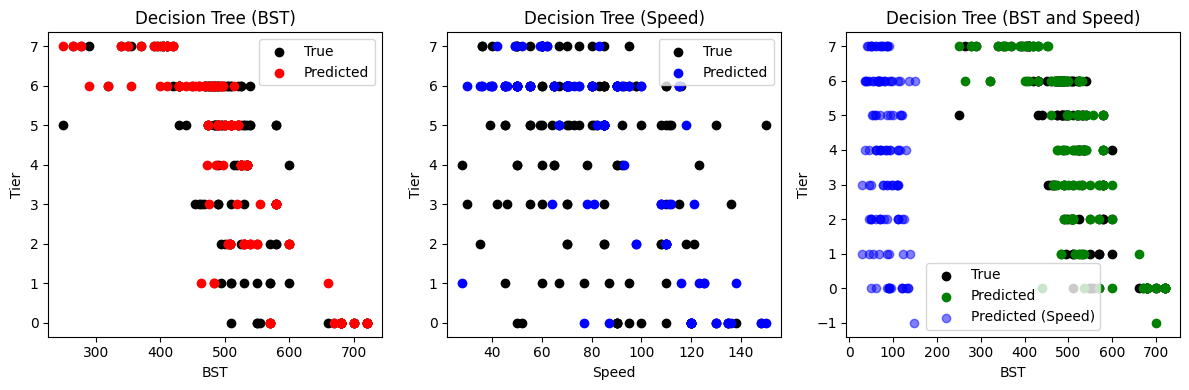

In [119]:
temp_best_df = bst_df
#temp_best_df['spe'] = bst_df['spe'].round()
#temp_best_df['bst'] = bst_df['bst'].round()
temp_best_df['mapped_tiers'] = bst_df['mapped_tiers'].round()
# Prepare the data
X_bst = temp_best_df[['bst']]
X_speed = temp_best_df[['spe']]
X_both = temp_best_df[['bst', 'spe']]
y = temp_best_df['mapped_tiers']

# Split the data into training and testing sets
X_bst_train, X_bst_test, y_train, y_test = train_test_split(X_bst, y, test_size=0.2, random_state=42)
X_speed_train, X_speed_test, _, _ = train_test_split(X_speed, y, test_size=0.2, random_state=42)
X_both_train, X_both_test, _, _ = train_test_split(X_both, y, test_size=0.2, random_state=42)

# Train decision tree models
model_bst = DecisionTreeClassifier(random_state=42)
model_speed = DecisionTreeClassifier(random_state=42)
model_both = DecisionTreeClassifier(random_state=42)

model_bst.fit(X_bst_train, y_train)
model_speed.fit(X_speed_train, y_train)
model_both.fit(X_both_train, y_train)

# Predictions
y_pred_bst = model_bst.predict(X_bst_test)
y_pred_speed = model_speed.predict(X_speed_test)
y_pred_both = model_both.predict(X_both_test)

# Calculate accuracies
accuracy_bst = accuracy_score(y_test, y_pred_bst)
accuracy_speed = accuracy_score(y_test, y_pred_speed)
accuracy_both = accuracy_score(y_test, y_pred_both)

# Print accuracies
print("Accuracy (BST):", accuracy_bst)
print("Accuracy (Speed):", accuracy_speed)
print("Accuracy (BST and Speed):", accuracy_both)

# Visualize decision trees
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Decision Tree (BST)")
plt.xlabel("BST")
plt.ylabel("Tier")
plt.scatter(X_bst_test, y_test, color='black', label='True')
plt.scatter(X_bst_test, y_pred_bst, color='red', label='Predicted')
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Decision Tree (Speed)")
plt.xlabel("Speed")
plt.ylabel("Tier")
plt.scatter(X_speed_test, y_test, color='black', label='True')
plt.scatter(X_speed_test, y_pred_speed, color='blue', label='Predicted')
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Decision Tree (BST and Speed)")
plt.xlabel("BST")
plt.ylabel("Tier")
plt.scatter(X_both_test['bst'], y_test, color='black', label='True')
plt.scatter(X_both_test['bst'], y_pred_both, color='green', label='Predicted')
plt.scatter(X_both_test['spe'], y_pred_both, color='blue', label='Predicted (Speed)', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# Analysis 
Here we see the opposite effect when it comes to determining tiering with bst as opposed to speed. However they are pretty close and pokemon is a varied game with more than just those factors impacting a pokemons ranking so this is to be expected. 